<a href="https://colab.research.google.com/github/marcomag416/MLDL/blob/main/lab03_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PyTorch AlexNet Exercises

Welcome to the PyTorch AlexNet exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.






In [ ]:
import requests
from zipfile import ZipFile
from io import BytesIO

# Define the path to the dataset
dataset_path = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'  # Replace with the path to your dataset

# Send a GET request to the URL
response = requests.get(dataset_path)
# Check if the request was successful
if response.status_code == 200:
    # Open the downloaded bytes and extract them
    with ZipFile(BytesIO(response.content)) as zip_file:
        zip_file.extractall('./dataset')
    print('Download and extraction complete!')

dataset_path = "./dataset/tiny-imagenet-200/train"


Download and extraction complete!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.manual_seed(27)

class Residual(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downSample = nn.Identity()
        if in_channels != out_channels:
          self.downSample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        return (self.conv(x) + self.downSample(x)).relu()

# Define the AlexNet architecture
class ResNet(nn.Module):
    def __init__(self, num_classes=200):  # Tiny ImageNet has 200 classes
        super(ResNet, self).__init__()
        # Define the layers of AlexNet
        self.layers_stack = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=2), #113x113
            nn.MaxPool2d(3, stride=2, padding=0), #55x55
            Residual(64, 64), #55x55
            Residual(64, 64),
            Residual(64, 64),
            Residual(64, 128, stride=2), #28x28
            Residual(128, 128),
            Residual(128, 128),
            Residual(128, 256, stride=2), #14x14
            Residual(256, 256),
            Residual(256, 256),
            Residual(256, 512, stride=2), #7x7
            Residual(512, 512),
            Residual(512, 512),
            nn.MaxPool2d(3, stride=2, padding=0), #3x3
            nn.Flatten(),
            nn.Linear(4608, num_classes),
        )

    def forward(self, x):
        x = self.layers_stack(x)
        return x


# Define transforms for the input data
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Resize images to match AlexNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the Tiny ImageNet dataset
# Note: You'll need to download the dataset and set the correct path.
dataset = datasets.ImageFolder(dataset_path, transform=transform)
#split dataset into 60% train 20% validation and 20% test
[train_dataset, val_dataset, test_dataset] = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(42))

# Training loop
def train(epoch, model, train_loader, criterion, optimizer, device, verbose=False):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # todo
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        '''
        What's the correct order of those instructions?
        1. optimizer.zero_grad()
        2. loss = criterion(outputs, targets)
        3. outputs = model(inputs)
        4. optimizer.step()
        5. loss.backward()

        '''
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    if(verbose):
      print(f'Train Epoch: {epoch} Loss: {train_loss:.6f} Acc: {train_accuracy:.2f}%')
    return train_accuracy

# Test loop
def test(model, test_loader, criterion, device, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    if(verbose):
      print(f'Test Loss: {test_loss:.6f} Acc: {test_accuracy:.2f}%')
    return test_accuracy

def plot_accuracies(train_accuracies, val_accuracies):
  #plot the results
  plt.figure(figsize=(8,6))
  plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train set")
  plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation set")

  plt.xlabel("Epoch")
  plt.ylabel("Accuracy [%]")

  plt.legend()

  plt.show()

def train_val_step(train_dataset, val_dataset, lr, batch_size, num_epochs):
  # Data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize the network
        net = ResNet(num_classes=200).cuda()

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

        train_accuracies = [0] * num_epochs
        val_accuracies = [0] * num_epochs
        # Train the network

        print(f"STARTING NEW COMBINATION. Learning rate: {lr}, batch size: {batch_size}, number of epochs: {num_epochs}")
        for epoch in tqdm(range(num_epochs)):
            # Training loop
            train_accuracies[epoch] = train(epoch, net, train_loader, criterion, optimizer, 'cuda', verbose=True)

            # Validation loop
            val_accuracies[epoch] = test(net, val_loader, criterion, 'cuda', verbose=False)

        # Evaluate on the validation set and print results
        test(net, val_loader, criterion, 'cuda', verbose=True)

        plot_accuracies(train_accuracies, val_accuracies)

        # You can save the model state if you want to keep it
        torch.save(net.state_dict(), f'alexnet_lr{lr}_bs{batch_size}.pth')


# To analyze the effect of weight decay, you can vary the weight_decay parameter
# in the SGD optimizer and repeat the training and evaluation process.


STARTING NEW COMBINATION. Learning rate: 0.1, batch size: 16, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.313388 Acc: 0.50%
Train Epoch: 1 Loss: 5.313546 Acc: 0.48%
Train Epoch: 2 Loss: 5.313225 Acc: 0.49%
Train Epoch: 3 Loss: 5.312596 Acc: 0.48%
Train Epoch: 4 Loss: 5.313421 Acc: 0.46%
Train Epoch: 5 Loss: 5.313506 Acc: 0.43%
Train Epoch: 6 Loss: 5.313700 Acc: 0.54%
Train Epoch: 7 Loss: 5.313455 Acc: 0.51%
Train Epoch: 8 Loss: 5.313332 Acc: 0.44%
Train Epoch: 9 Loss: 5.313392 Acc: 0.51%
Test Loss: 5.309692 Acc: 0.43%


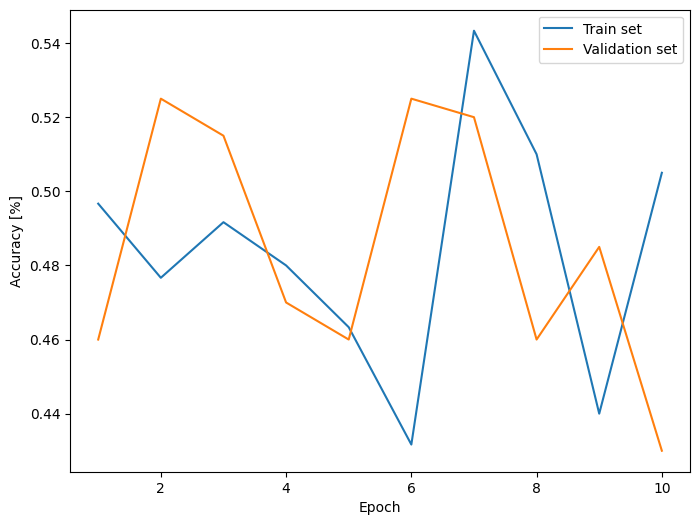

STARTING NEW COMBINATION. Learning rate: 0.1, batch size: 32, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.306198 Acc: 0.45%
Train Epoch: 1 Loss: 5.305830 Acc: 0.50%
Train Epoch: 2 Loss: 5.306451 Acc: 0.47%
Train Epoch: 3 Loss: 5.306172 Acc: 0.44%
Train Epoch: 4 Loss: 5.305961 Acc: 0.47%
Train Epoch: 5 Loss: 5.305785 Acc: 0.54%
Train Epoch: 6 Loss: 5.306154 Acc: 0.49%
Train Epoch: 7 Loss: 5.306724 Acc: 0.45%
Train Epoch: 8 Loss: 5.306117 Acc: 0.57%
Train Epoch: 9 Loss: 5.306550 Acc: 0.46%
Test Loss: 5.304661 Acc: 0.53%


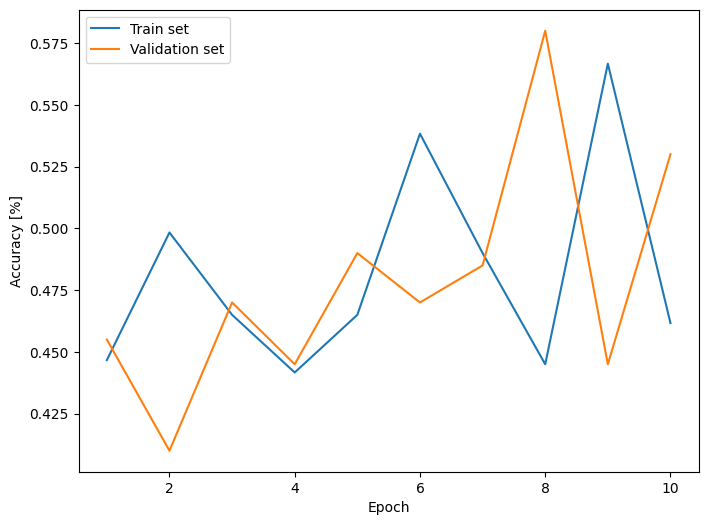

STARTING NEW COMBINATION. Learning rate: 0.1, batch size: 64, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.117803 Acc: 1.97%
Train Epoch: 1 Loss: nan Acc: 2.31%
Train Epoch: 2 Loss: nan Acc: 0.49%
Train Epoch: 3 Loss: nan Acc: 0.49%
Train Epoch: 4 Loss: nan Acc: 0.49%
Train Epoch: 5 Loss: nan Acc: 0.49%
Train Epoch: 6 Loss: nan Acc: 0.49%
Train Epoch: 7 Loss: nan Acc: 0.49%
Train Epoch: 8 Loss: nan Acc: 0.49%
Train Epoch: 9 Loss: nan Acc: 0.49%
Test Loss: nan Acc: 0.53%


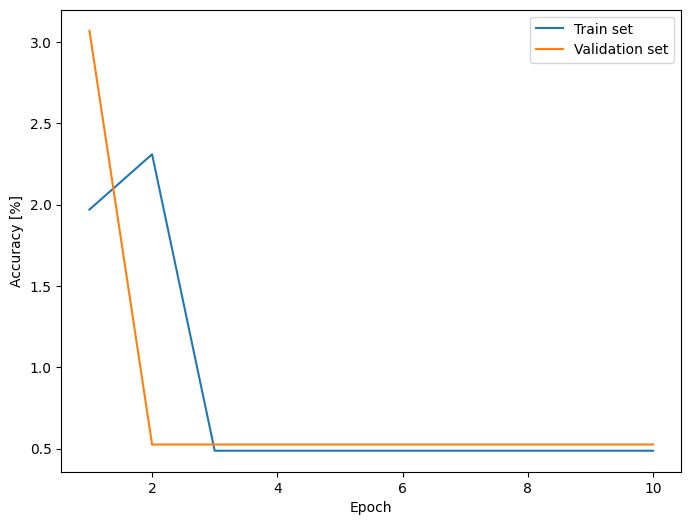

In [ ]:
# Hyperparameters
learning_rates = [0.1]
batch_sizes = [16, 32, 64]
num_epochs = 10

torch.manual_seed(27)

# Loop over hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        train_val_step(train_dataset, val_dataset, lr, batch_size, num_epochs)

STARTING NEW COMBINATION. Learning rate: 0.001, batch size: 16, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.318411 Acc: 2.22%
Train Epoch: 1 Loss: 4.447251 Acc: 9.85%
Train Epoch: 2 Loss: 3.814819 Acc: 18.47%
Train Epoch: 3 Loss: 3.317091 Acc: 26.19%
Train Epoch: 4 Loss: 2.881057 Acc: 33.84%
Train Epoch: 5 Loss: 2.443281 Acc: 41.98%
Train Epoch: 6 Loss: 1.989532 Acc: 51.23%
Train Epoch: 7 Loss: 1.492371 Acc: 62.27%
Train Epoch: 8 Loss: 0.994826 Acc: 74.08%
Train Epoch: 9 Loss: 0.551788 Acc: 85.33%
Test Loss: 4.557274 Acc: 28.30%


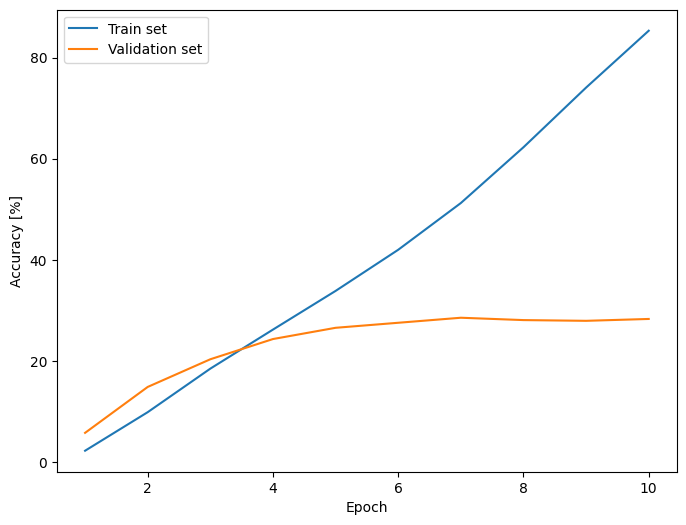

STARTING NEW COMBINATION. Learning rate: 0.001, batch size: 32, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.177038 Acc: 3.57%
Train Epoch: 1 Loss: 4.276793 Acc: 12.20%
Train Epoch: 2 Loss: 3.710226 Acc: 20.20%
Train Epoch: 3 Loss: 3.237520 Acc: 27.91%
Train Epoch: 4 Loss: 2.818402 Acc: 35.23%
Train Epoch: 5 Loss: 2.389190 Acc: 43.66%
Train Epoch: 6 Loss: 1.955056 Acc: 52.17%
Train Epoch: 7 Loss: 1.497283 Acc: 62.28%
Train Epoch: 8 Loss: 1.014859 Acc: 73.65%
Train Epoch: 9 Loss: 0.567650 Acc: 85.01%
Test Loss: 3.755510 Acc: 29.70%


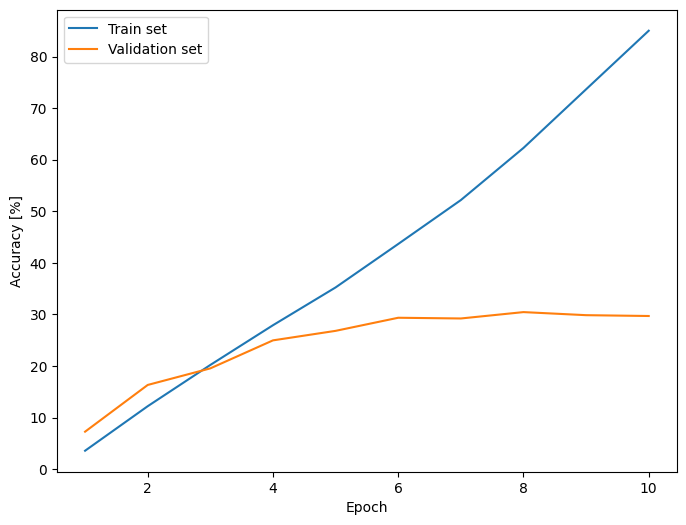

STARTING NEW COMBINATION. Learning rate: 0.001, batch size: 64, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.240446 Acc: 2.63%
Train Epoch: 1 Loss: 4.387438 Acc: 10.06%
Train Epoch: 2 Loss: 3.801058 Acc: 17.95%
Train Epoch: 3 Loss: 3.342930 Acc: 25.53%
Train Epoch: 4 Loss: 2.963631 Acc: 32.11%
Train Epoch: 5 Loss: 2.605764 Acc: 38.66%
Train Epoch: 6 Loss: 2.244846 Acc: 45.73%
Train Epoch: 7 Loss: 1.858328 Acc: 53.62%
Train Epoch: 8 Loss: 1.435089 Acc: 63.33%
Train Epoch: 9 Loss: 0.983408 Acc: 74.01%
Test Loss: 3.584871 Acc: 29.43%


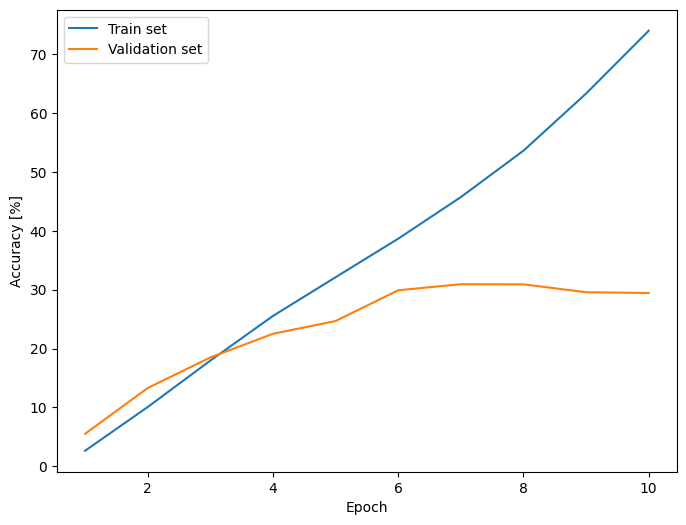

In [ ]:
# Hyperparameters
learning_rates = [0.001]
batch_sizes = [16, 32, 64]
num_epochs = 10

torch.manual_seed(27)

# Loop over hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        train_val_step(train_dataset, val_dataset, lr, batch_size, num_epochs)

STARTING NEW COMBINATION. Learning rate: 0.0001, batch size: 16, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.095697 Acc: 3.12%
Train Epoch: 1 Loss: 4.469311 Acc: 8.62%
Train Epoch: 2 Loss: 4.039667 Acc: 14.01%
Train Epoch: 3 Loss: 3.678524 Acc: 19.41%
Train Epoch: 4 Loss: 3.360052 Acc: 24.50%
Train Epoch: 5 Loss: 3.073676 Acc: 29.48%
Train Epoch: 6 Loss: 2.797275 Acc: 34.70%
Train Epoch: 7 Loss: 2.491833 Acc: 40.12%
Train Epoch: 8 Loss: 2.157207 Acc: 47.27%
Train Epoch: 9 Loss: 1.773393 Acc: 55.64%
Test Loss: 3.357892 Acc: 28.70%


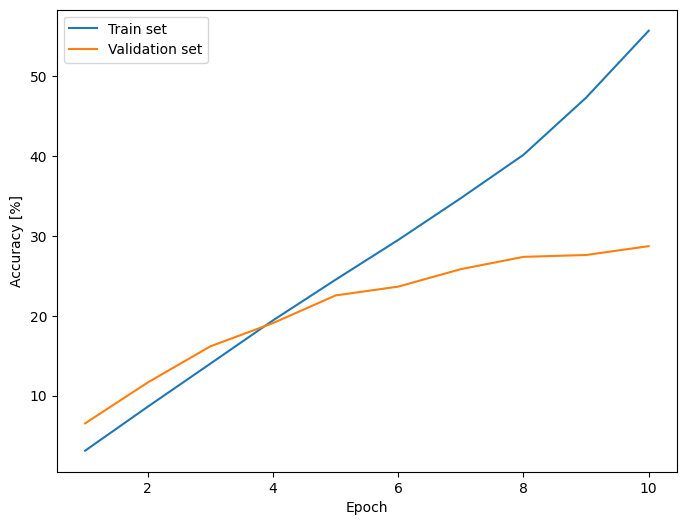

STARTING NEW COMBINATION. Learning rate: 0.0001, batch size: 32, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.122843 Acc: 3.33%
Train Epoch: 1 Loss: 4.463517 Acc: 8.88%
Train Epoch: 2 Loss: 4.065477 Acc: 14.19%
Train Epoch: 3 Loss: 3.738478 Acc: 18.65%
Train Epoch: 4 Loss: 3.436296 Acc: 23.38%
Train Epoch: 5 Loss: 3.135544 Acc: 28.62%
Train Epoch: 6 Loss: 2.840213 Acc: 34.05%
Train Epoch: 7 Loss: 2.532596 Acc: 40.30%
Train Epoch: 8 Loss: 2.207273 Acc: 47.35%
Train Epoch: 9 Loss: 1.865322 Acc: 55.61%
Test Loss: 3.470790 Acc: 24.85%


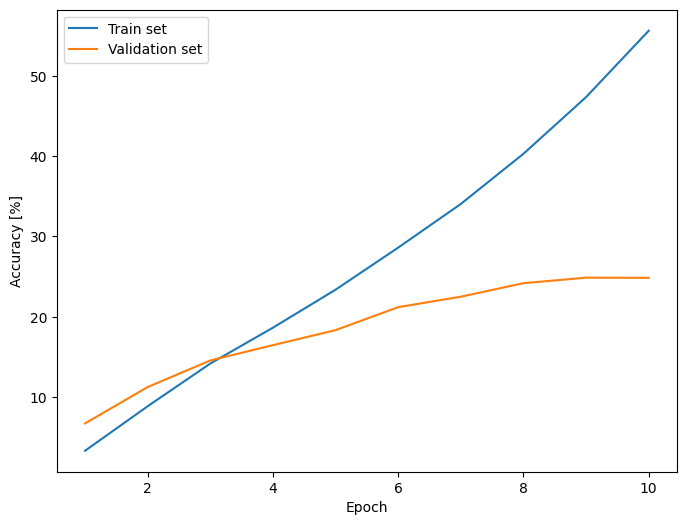

STARTING NEW COMBINATION. Learning rate: 0.0001, batch size: 64, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.182820 Acc: 2.72%
Train Epoch: 1 Loss: 4.546460 Acc: 8.00%
Train Epoch: 2 Loss: 4.132794 Acc: 13.29%
Train Epoch: 3 Loss: 3.805959 Acc: 18.11%
Train Epoch: 4 Loss: 3.516669 Acc: 22.80%
Train Epoch: 5 Loss: 3.236099 Acc: 27.71%
Train Epoch: 6 Loss: 2.959420 Acc: 33.10%
Train Epoch: 7 Loss: 2.680908 Acc: 39.23%
Train Epoch: 8 Loss: 2.389028 Acc: 45.91%
Train Epoch: 9 Loss: 2.108109 Acc: 52.70%
Test Loss: 3.703163 Acc: 20.48%


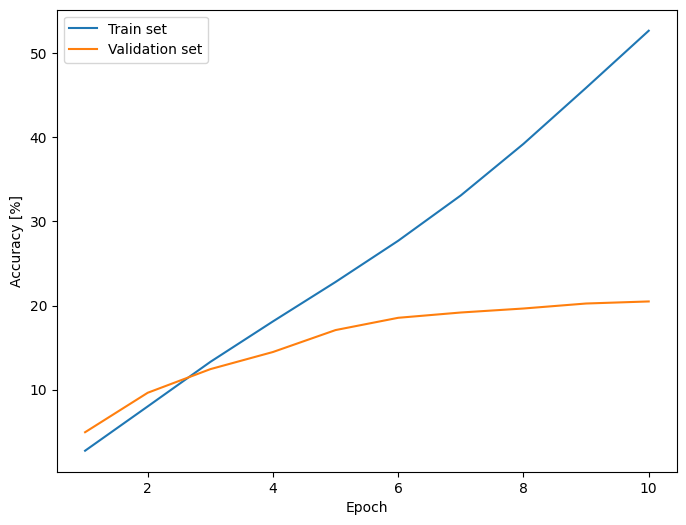

In [ ]:
# Hyperparameters
learning_rates = [0.0001]
batch_sizes = [16, 32, 64]
num_epochs = 10

torch.manual_seed(27)

# Loop over hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        train_val_step(train_dataset, val_dataset, lr, batch_size, num_epochs)

## Test - use pretrained ResNet

In [ ]:
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"
ptModel = torchvision.models.resnet34(weights='DEFAULT').to(device)

#freeze feature layers
for param in ptModel.parameters():
    param.requires_grad = False

num_epochs=10
batch_size = 64

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate the classifier layer and seed it to the target device
ptModel.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=512,
                    out_features=200, # same number of output units as our number of classes
                    bias=True)).to(device)

# Define transforms for the input data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match AlexNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the Tiny ImageNet dataset
# Note: You'll need to download the dataset and set the correct path.
dataset = datasets.ImageFolder(dataset_path, transform=transform)
#split dataset into 60% train 20% validation and 20% test
[train_dataset, val_dataset, test_dataset] = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(42))

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 2.729380 Acc: 41.73%
Train Epoch: 1 Loss: 1.818041 Acc: 55.88%
Train Epoch: 2 Loss: 1.703234 Acc: 58.07%
Train Epoch: 3 Loss: 1.649481 Acc: 59.05%
Train Epoch: 4 Loss: 1.619042 Acc: 59.71%
Train Epoch: 5 Loss: 1.605778 Acc: 59.91%
Train Epoch: 6 Loss: 1.602013 Acc: 59.90%
Train Epoch: 7 Loss: 1.582263 Acc: 60.25%
Train Epoch: 8 Loss: 1.576232 Acc: 60.56%
Train Epoch: 9 Loss: 1.577904 Acc: 60.67%


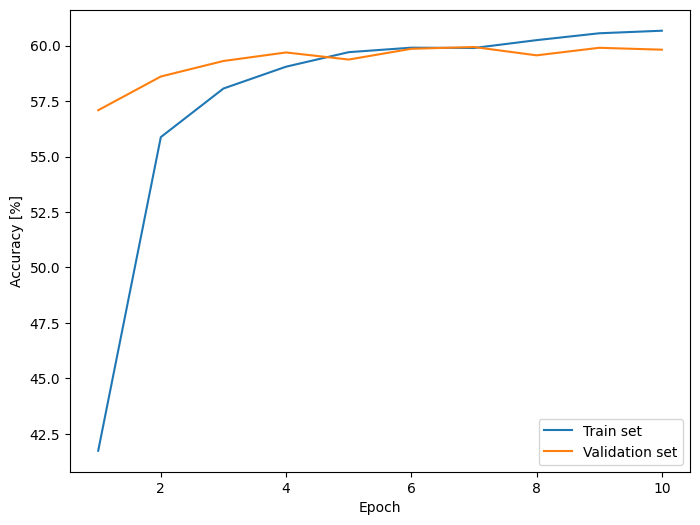

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ptModel.parameters(), lr=1e-3)


train_acc = [] * num_epochs
val_acc = [] * num_epochs

for epoch in tqdm(range(num_epochs)):
    train_acc.append(train(epoch, ptModel, train_loader, criterion, optimizer, 'cuda', verbose=True))
    val_acc.append(test(ptModel, val_loader, criterion, 'cuda', verbose=False))

plot_accuracies(train_acc, val_acc)